In [1]:
 %matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

##  Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

##  Exploratory Climate Analysis

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Find last date in table:
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)

('2017-08-23',)


In [10]:
# Calculate the date 1 year ago from the last data point in the database
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [11]:
# Perform a query to retrieve the data and precipitation scores
rain = (session.query(Measurement.date, Measurement.prcp)
           .filter(Measurement.date>=last_year)
           .order_by(Measurement.date).all())
print(rain)

[('2016-08-23', 0.0), ('2016-08-23', 0.15), ('2016-08-23', 0.05), ('2016-08-23', None), ('2016-08-23', 0.02), ('2016-08-23', 1.79), ('2016-08-23', 0.7), ('2016-08-24', 0.08), ('2016-08-24', 2.15), ('2016-08-24', 2.28), ('2016-08-24', None), ('2016-08-24', 1.22), ('2016-08-24', 2.15), ('2016-08-24', 1.45), ('2016-08-25', 0.08), ('2016-08-25', 0.08), ('2016-08-25', 0.0), ('2016-08-25', 0.0), ('2016-08-25', 0.21), ('2016-08-25', 0.06), ('2016-08-25', 0.11), ('2016-08-26', 0.0), ('2016-08-26', 0.03), ('2016-08-26', 0.02), ('2016-08-26', 0.04), ('2016-08-26', 0.0), ('2016-08-26', 0.01), ('2016-08-27', 0.0), ('2016-08-27', 0.18), ('2016-08-27', 0.02), ('2016-08-27', 0.0), ('2016-08-27', 0.12), ('2016-08-27', None), ('2016-08-28', 0.01), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.14), ('2016-08-28', 0.6), ('2016-08-28', 2.07), ('2016-08-29', 0.0), ('2016-08-29', 0.17), ('2016-08-29', 0.04), ('2016-08-29', None), ('2016-08-29', 0.0), ('2016-08-29', 0.35), ('2016-08-29', 0.9),

In [12]:
# Save the query results as a Pandas DataFrame and set the index to the date column
rain_df = pd.DataFrame(rain, columns=['Date', 'Precipitation']).dropna()
rain_df.set_index('Date', inplace=True)
rain_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [13]:
# Sort the dataframe by date
rain_df = rain_df.sort_values('Date')
rain_df.head(10)

,Precipitation
Date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79
2016-08-23,0.70
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28


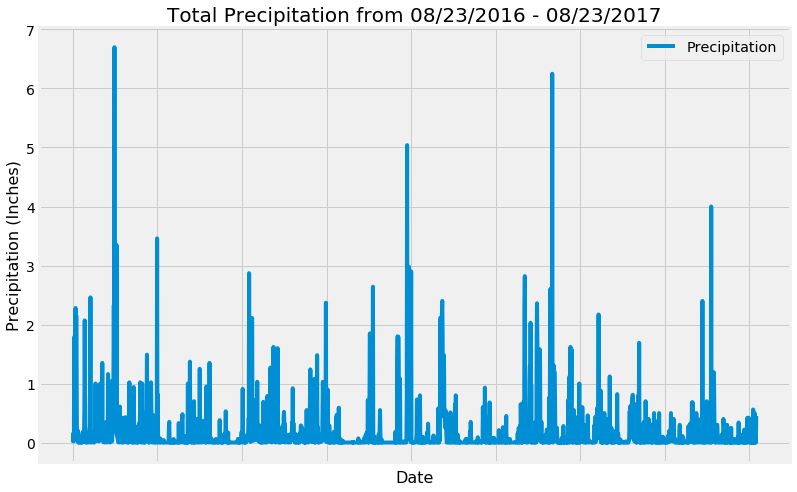

In [68]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_df.plot(figsize=(12,8))
plt.ylabel('Precipitation (Inches)', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.title('Total Precipitation from 08/23/2016 - 08/23/2017', fontsize=20)
plt.legend(fontsize='x-large')
plt.yticks(fontsize=14)
plt.savefig('./Output/total_precip.png')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
rain_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.id).count()
print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = (session.query(Measurement.station, func.count(Measurement.station))
                   .order_by(func.count(Measurement.station).desc()).group_by(Measurement.station)).all()
stations_df = pd.DataFrame(active_stations, columns=['Station', 'Count'])
stations_df

,Station,Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active = active_stations[0][0]

temp = [func.min(Measurement.tobs), 
        func.max(Measurement.tobs), 
        func.avg(Measurement.tobs)]

most_active_station = session.query(*temp).filter(Measurement.station==most_active).all()
print(most_active_station)

[(54.0, 85.0, 71.66378066378067)]


In [31]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station  
highest_obs = (session.query(Measurement.station, Measurement.tobs)
               .filter(Measurement.station == most_active)
               .filter(Measurement.date >= last_year).all())
obs_df = pd.DataFrame(highest_obs, columns=['Station', 'Tobs'])
obs_df.set_index('Station', inplace=True)
obs_df.head(10)

,Tobs
Station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0
USC00519281,73.0
USC00519281,78.0
USC00519281,77.0
USC00519281,78.0


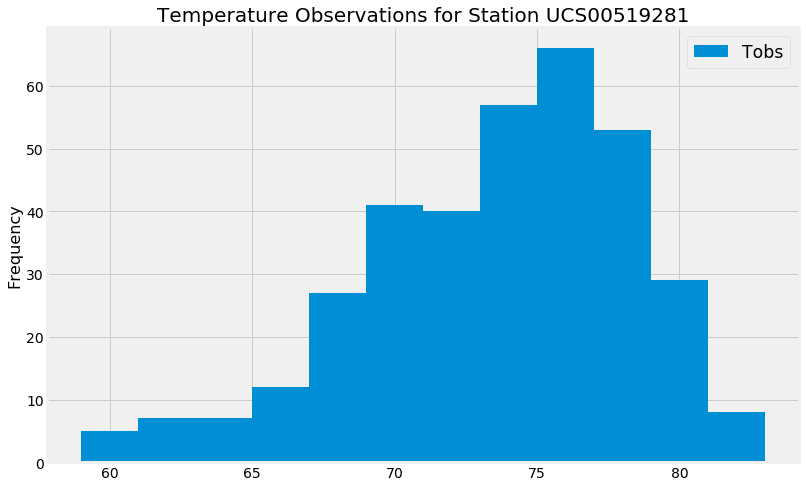

In [67]:
# Plot the results as a histogram
obs_df.plot(kind="hist", bins=12, figsize=(12, 8))
plt.legend(fontsize='xx-large')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Frequency', fontsize=16)
plt.title('Temperature Observations for Station UCS00519281', fontsize=20)
plt.savefig('./Output/temp_obs.png')
plt.show()

In [42]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [51]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temp = (calc_temps('2017-01-01', '2017-12-31'))

trip_df = pd.DataFrame(trip_temp, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
trip_df

,Min Temp,Avg Temp,Max Temp
0,58.0,74.14388,87.0


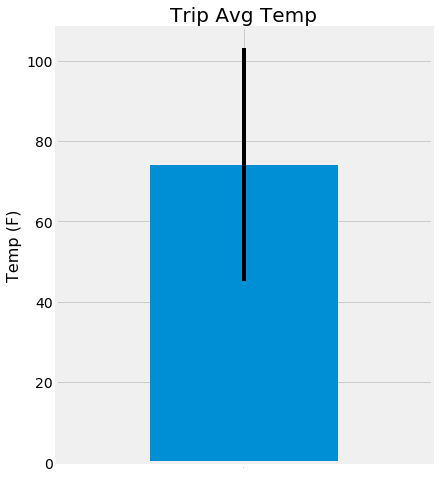

In [66]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(6, 8))
plt.yticks(fontsize=14)
plt.ylabel('Temp (F)', fontsize=16)
plt.xticks(fontsize=0)
plt.title('Trip Avg Temp', fontsize=20)
plt.savefig('./Output/trip_avg_temp.png')
plt.show()